In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
input_size = 3
hidden_sizes = [2, 3] 
output_size = 1
initial_activation_list = [jax.nn.relu]

homo_config = MLPConfig(input_size=input_size,
                        output_size=output_size,
                        hidden_sizes=hidden_sizes,
                        initial_activation_list=initial_activation_list,
                        seed=42)

In [ ]:
mlp = CustomMLP(homo_config)

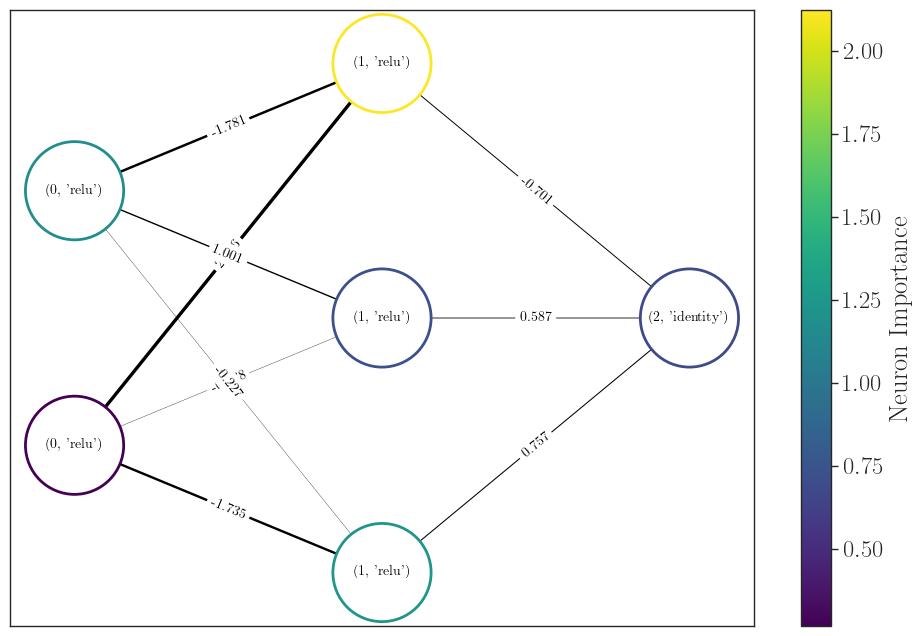

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
mlp = CustomMLP(homo_config)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

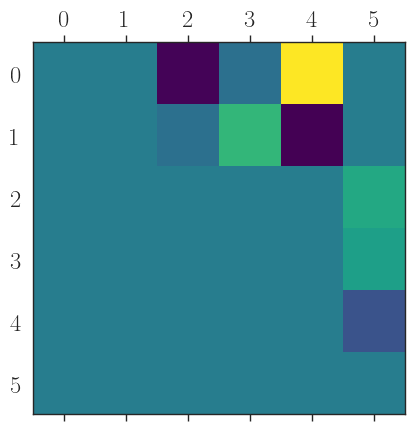

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)

In [ ]:
activation_list = [jax.nn.relu, sin, jax.nn.tanh]
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
key = jax.random.PRNGKey(42)
Loss_history = []
Node_history = []
graph_history = []

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)

    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0 and jax.random.uniform(add_key) < 0.05:
        add_key, act_key = jax.random.split(add_key)
        activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
        layers = len(mlp.get_shape()) - 1
        layer = jax.random.randint(act_key, (1,), 0, layers)[0]
        mlp.add_neuron(layer_index=1, activation=activation, key=add_key)
        opt_state = initialize_optimizer_state(mlp, opt)
        print(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
        print(mlp.get_shape())
    
    elif (epoch + 1) % remove_node_every == 0 and jax.random.uniform(sub_key) < 0.05:
        layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
        layers = len(mlp.get_shape()) - 1
        layer = jax.random.randint(layer_key, (1,), 0, layers)[0]
        layer_neurons = len(mlp.layers[layer])
        if layer_neurons > 0:
            neuron_idx = jax.random.randint(neuron_key, (1,), 0, layer_neurons)[0]
            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            print(f"Removed neuron from hidden layer {layer+1} at index {neuron_idx}")
            print(mlp.get_shape())

    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

print("Final Prediction:", mlp(x))

Epoch 0, Prediction: 1.30978262424469, Loss: 5.648972034454346
Epoch 1, Prediction: 1.1386868953704834, Loss: 0.09596527367830276
Epoch 2, Prediction: 1.0649170875549316, Loss: 0.019234055653214455
Epoch 3, Prediction: 1.030922770500183, Loss: 0.004214228130877018
Epoch 4, Prediction: 1.0148439407348633, Loss: 0.0009562177583575249
Epoch 5, Prediction: 1.0071512460708618, Loss: 0.00022034258290659636
Epoch 6, Prediction: 1.0034509897232056, Loss: 5.114031955599785e-05
Epoch 7, Prediction: 1.0016666650772095, Loss: 1.1909330169146415e-05
Epoch 8, Prediction: 1.000805139541626, Loss: 2.7777725790656405e-06
Epoch 9, Prediction: 1.0003892183303833, Loss: 6.482496814896876e-07
Epoch 10, Prediction: 1.0001881122589111, Loss: 1.5149090870636428e-07
Epoch 11, Prediction: 1.0000909566879272, Loss: 3.5386221952649066e-08
Epoch 12, Prediction: 1.0000437498092651, Loss: 8.273119078694435e-09
Epoch 13, Prediction: 1.00002121925354, Loss: 1.9140458107358427e-09
Epoch 14, Prediction: 1.00001001358032

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

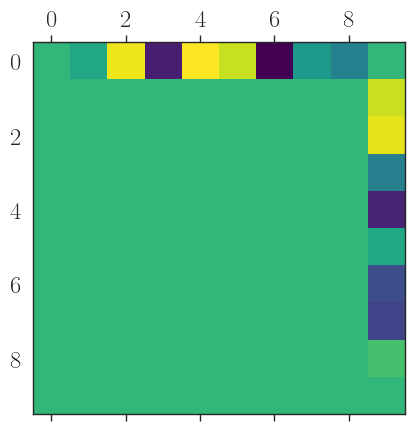

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)

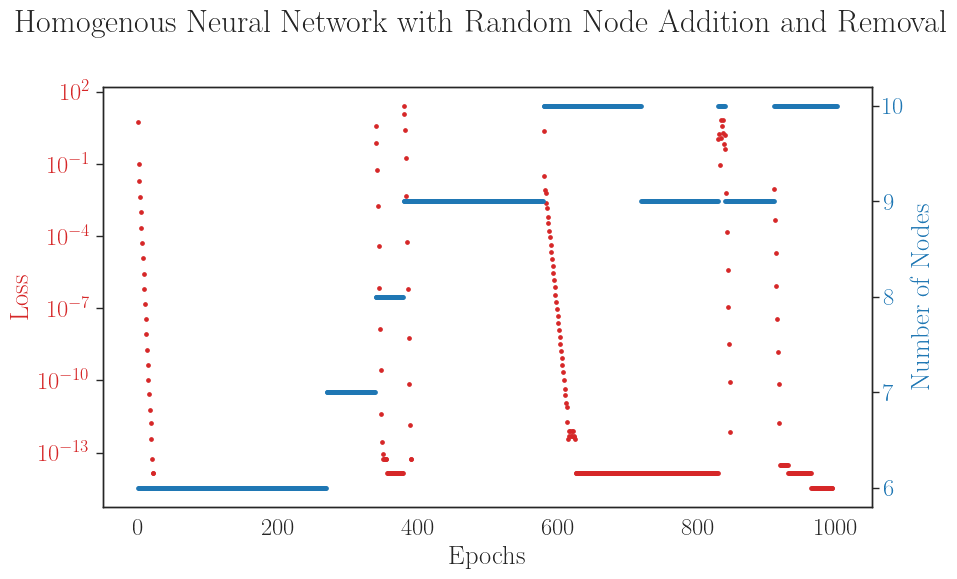

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Homogenous Neural Network with Random Node Addition and Removal")
fig.tight_layout()

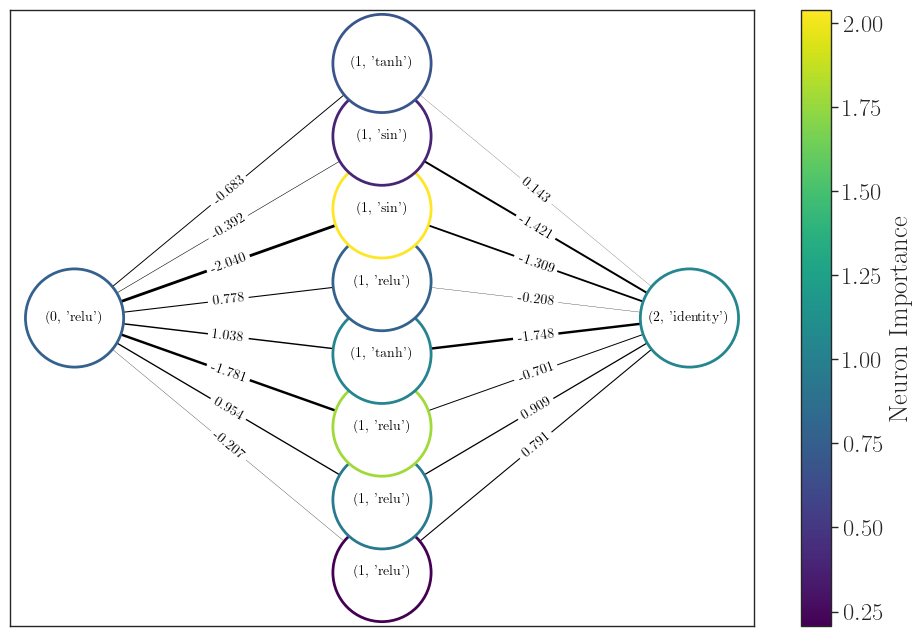

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()